In [1]:
import json
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [222]:
GROUP_MAP = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP = {k.replace(':', '_'): v for k, v in GROUP_MAP.items()}

GROUP_MAP_CEQ = {
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP_CEQ = {k.replace(':', '_'): v for k, v in GROUP_MAP_CEQ.items()}

GROUP_MAP_CW = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
}
GROUP_MAP_CW = {k.replace(':', '_'): v for k, v in GROUP_MAP_CW.items()}

MAP_AUDIO_TASK = {
    "ASR": "Automatic_speech_recognition",
    "SER": "Speech_emotion_recognition",
    "GR": "Gender_recognition",
    # "MMAU": "MMAU", # not implemented yet
}

MAP_MODEL_NAME = {
    "qwen": "Qwen-Audio",
    "qwen2": "Qwen2-Audio",
    "blsp-emo": "BLSP-Emo",
    "desta2_5": "DeSTA2.5-Audio",
}

MODEL_ORDER = list(MAP_MODEL_NAME.keys())
GROUP_ORDER_CEQ = ["change_case", "startend", "wrapping", "json_format"]
GROUP_ORDER_CW = ["bullet_lists", "keywords", "length_constraints"]

In [220]:
df_audio_task_ceq = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_ceq[audio_task] = pd.read_excel(f"./analysis/summary_ceq.xlsx", sheet_name=f"{audio_task}_grouped")

df_audio_task_cot = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cot[audio_task] = pd.read_excel(f"./analysis/summary_CoT.xlsx", sheet_name=audio_task)

df_audio_task_cw = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cw[audio_task] = pd.read_excel(f"./analysis/summary_cw.xlsx", sheet_name=f"{audio_task}_grouped")

In [ ]:
outs = {}
for k, v in df_audio_task_ceq.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

In [295]:
DF_audio_task_ceq = pd.concat(
    list(df_audio_task_ceq.values()),
    keys=list(df_audio_task_ceq.keys()),
    names=["audio_task"]
).reset_index()

In [259]:
DF_ceq = DF_audio_task_ceq.groupby(["IF_task_group", "model", "shot_level"]).mean(numeric_only=True).reset_index()
DF_ceq["model"] = pd.Categorical(DF_ceq["model"], categories=MODEL_ORDER, ordered=True)
DF_ceq["IF_task_group"] = pd.Categorical(DF_ceq["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

In [205]:
pt_ceq = DF_ceq.pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate_strict",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_ceq["Avg."] = pt_ceq.mean(axis=1)

In [218]:
pt_0 = pt_ceq.loc[:, 0, :]
pt_k = pt_ceq[pt_ceq.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_ceq = pd.concat([pt_0, pt_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_ceq = tb_ceq.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_ceq * 100, 2)


IF_task_group       change_case  startend  wrapping  json_format   Avg.
model    Setting                                                       
qwen     Zero-shot         3.33     10.67      3.33        24.67  10.50
         ICL               2.42     23.67      3.00        10.50   9.90
qwen2    Zero-shot        79.33     72.00     22.00         0.00  43.33
         ICL              55.50     62.67     17.92         0.25  34.08
blsp-emo Zero-shot        80.67     62.67     48.67       100.00  73.00
         ICL              50.67     47.42     51.75         1.75  37.90
desta2_5 Zero-shot       100.00     94.67     91.33        98.67  96.17
         ICL              92.33     62.92     78.42        32.00  66.42

In [ ]:
tb_ceq.to_csv("./analysis/tables_ceq.csv", index=True)

In [294]:
DF_audio_task_cw = pd.concat(
    list(df_audio_task_cw.values()),
    keys=list(df_audio_task_cw.keys()),
    names=["audio_task"]
).reset_index().drop(columns=["level_1"]).dropna()
DF_audio_task_cw["model"] = pd.Categorical(DF_audio_task_cw["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task_cw["IF_task_group"] = pd.Categorical(DF_audio_task_cw["IF_task_group"], categories=GROUP_ORDER_CW, ordered=True)

pt_cw = DF_audio_task_cw.groupby(["IF_task_group", "model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cw = pt_cw.reset_index().pivot_table(
    index=["model", "shot_level"],
    columns="IF_task_group",
    values="if_rate",
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_cw["Avg."] = pt_cw.mean(axis=1)

In [238]:
pt_0_cw = pt_cw.loc[:, 0, :]
pt_k_cw = pt_cw[pt_cw.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cw = pd.concat([pt_0_cw, pt_k_cw], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cw = tb_cw.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cw.to_csv("./analysis/tables_cw.csv", index=True)
round(tb_cw * 100, 2)

IF_task_group       bullet_lists  keywords  length_constraints   Avg.
model    Setting                                                     
qwen     Zero-shot         69.63     51.00               42.09  54.24
         ICL               56.97     63.62               39.36  53.32
qwen2    Zero-shot         86.85     75.00               55.28  72.38
         ICL               77.05     82.62               57.92  72.53
blsp-emo Zero-shot         77.96     57.00               58.78  64.58
         ICL               82.88     55.75               68.45  69.03
desta2_5 Zero-shot         91.02     88.00               81.50  86.84
         ICL               96.16     88.62               90.93  91.90

In [304]:
DF_audio_task_cot = pd.concat(
    list(df_audio_task_cot.values()),
    keys=list(df_audio_task_cot.keys()),
).reset_index().rename(columns={"level_0": "audio_task"})
DF_audio_task_cot["model"] = pd.Categorical(DF_audio_task_cot["model"], categories=MODEL_ORDER, ordered=True)
pt_cot = DF_audio_task_cot.groupby(["model", "shot_level"], observed=False).mean(numeric_only=True)
pt_cot = pt_cot.reset_index().pivot_table(
    index=["model", "shot_level"],
    values="CoT Acc",
    aggfunc="mean",
    observed=False,
    sort=False,
)

In [275]:
DF_audio_task_cot

,level_0,level_1,IF_task_group,IF_task,n,model,shot_level,CoT Acc,task wer,Task Acc
0,ASR,0,cot,cot,38,blsp-emo,0,0.236842,0.411693,NaN
1,ASR,1,cot,cot,38,blsp-emo,1,0.947368,17.344702,NaN
2,ASR,2,cot,cot,38,blsp-emo,2,0.921053,9.183922,NaN
3,ASR,3,cot,cot,38,blsp-emo,3,0.947368,1.075518,NaN
4,ASR,4,cot,cot,38,blsp-emo,4,0.921053,1.085262,NaN
...,...,...,...,...,...,...,...,...,...,...
103,SER,31,cot,cot,40,qwen2,4,0.850000,NaN,0.400
104,SER,32,cot,cot,40,qwen2,5,0.825000,NaN,0.475
105,SER,33,cot,cot,40,qwen2,6,0.875000,NaN,0.500
106,SER,34,cot,cot,40,qwen2,7,0.850000,NaN,0.500


In [255]:
pt_0_cot = pt_cot.loc[:, 0, :]
pt_k_cot = pt_cot[pt_cot.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_cot = pd.concat([pt_0_cot, pt_k_cot], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_cot = tb_cot.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
tb_cot.to_csv("./analysis/tables_cot.csv", index=True)
round(tb_cot * 100  , 2)

CoT Acc
model    Setting           
qwen     Zero-shot    13.67
         ICL          17.49
qwen2    Zero-shot    28.34
         ICL          57.07
blsp-emo Zero-shot    60.79
         ICL          93.76
desta2_5 Zero-shot    87.07
         ICL          98.09

In [258]:
tb_if = pd.concat([tb_ceq, tb_cw, tb_cot], axis=1, keys=["CEQ", "CW", "CoT"])
tb_if.to_csv("./analysis/tables_if_rate.csv", index=True)
round(tb_if, 2) * 100

CEQ                                      \
                   change_case startend wrapping json_format  Avg.   
model    Setting                                                     
qwen     Zero-shot         3.0     11.0      3.0        25.0  11.0   
         ICL               2.0     24.0      3.0        11.0  10.0   
qwen2    Zero-shot        79.0     72.0     22.0         0.0  43.0   
         ICL              56.0     63.0     18.0         0.0  34.0   
blsp-emo Zero-shot        81.0     63.0     49.0       100.0  73.0   
         ICL              51.0     47.0     52.0         2.0  38.0   
desta2_5 Zero-shot       100.0     95.0     91.0        99.0  96.0   
         ICL              92.0     63.0     78.0        32.0  66.0   

                             CW                                       CoT  
                   bullet_lists keywords length_constraints  Avg. CoT Acc  
model    Setting                                                           
qwen     Zero-shot         70.0     51.0               42.0  54.0    14.0  
         ICL               57.0     64.0               39.0  53.0    17.0  
qwen2    Zero-shot         87.0     75.0               55.0  72.0    28.0  
         ICL               77.0     83.0               58.0  73.0    57.0  
blsp-emo Zero-shot         78.0     57.0               59.0  65.0    61.0  
         ICL               83.0     56.0               68.0  69.0    94.0  
desta2_5 Zero-shot         91.0     88.0               82.0  87.0    87.0  
         ICL               96.0     89.0               91.0  92.0    98.0

In [268]:
DF_audio_task_ceq["model"] = pd.Categorical(DF_audio_task_ceq["model"], categories=MODEL_ORDER, ordered=True)
DF_audio_task_ceq.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True)

level_1      n  if_rate_strict  if_rate_loose  \
model    audio_task shot_level                                                  
qwen     ASR        0               6.0  31.25           0.140          0.175   
                    1              22.0  31.25           0.120          0.120   
                    2              38.0  31.25           0.090          0.090   
                    3              54.0  31.25           0.105          0.105   
                    4              70.0  31.25           0.120          0.120   
...                                 ...    ...             ...            ...   
desta2_5 SER        4              72.0  31.25           0.665          0.665   
                    5              88.0  31.25           0.610          0.610   
                    6             104.0  31.25           0.590          0.590   
                    7             120.0  31.25           0.555          0.555   
                    8             136.0  31.25           0.530          0.530   

                                mean_performance  
model    audio_task shot_level                    
qwen     ASR        0                   0.945694  
                    1                   1.360599  
                    2                   1.429709  
                    3                   1.369474  
                    4                   1.338705  
...                                          ...  
desta2_5 SER        4                   0.410000  
                    5                   0.390000  
                    6                   0.405000  
                    7                   0.385000  
                    8                   0.380000  

[108 rows x 5 columns]

In [ ]:
DF_audio_task_ceq = DF_audio_task_ceq.rename(columns={"if_rate_strict": "IF Rate"})
DF_audio_task_cw = DF_audio_task_cw.rename(columns={"if_rate": "IF Rate"})
DF_audio_task_cot["mean_performance"] = DF_audio_task_cot["Task Acc"].fillna(0) + DF_audio_task_cot["task wer"].fillna(0)
DF_audio_task_cot = DF_audio_task_cot.rename(columns={"CoT Acc": "IF Rate"})

In [326]:
DFs = [
    DF_audio_task_ceq.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
    DF_audio_task_cw.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
    DF_audio_task_cot.groupby(["model", "audio_task", "shot_level"], observed=False).mean(numeric_only=True),
]
DF_audio_task = pd.concat(DFs, keys=["CEQ", "CW", "CoT"], names=["response_task"]).reset_index()
DF_audio_task["model"] = pd.Categorical(DF_audio_task["model"], categories=MODEL_ORDER, ordered=True)

In [327]:
DF_audio_task

,response_task,model,audio_task,shot_level,level_1,n,IF Rate,if_rate_loose,mean_performance,task wer,Task Acc
0,CEQ,blsp-emo,ASR,0,9.0,31.25,0.810,0.810,0.177106,NaN,NaN
1,CEQ,blsp-emo,ASR,1,25.0,31.25,0.430,0.430,0.265110,NaN,NaN
2,CEQ,blsp-emo,ASR,2,41.0,31.25,0.365,0.365,0.269303,NaN,NaN
3,CEQ,blsp-emo,ASR,3,57.0,31.25,0.365,0.365,0.272582,NaN,NaN
4,CEQ,blsp-emo,ASR,4,73.0,31.25,0.370,0.370,0.278780,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
319,CoT,desta2_5,SER,4,13.0,40.00,0.975,NaN,0.525000,NaN,0.525
320,CoT,desta2_5,SER,5,14.0,40.00,1.000,NaN,0.525000,NaN,0.525
321,CoT,desta2_5,SER,6,15.0,40.00,1.000,NaN,0.600000,NaN,0.600
322,CoT,desta2_5,SER,7,16.0,40.00,1.000,NaN,0.500000,NaN,0.500


In [328]:
pt_audio_tasks = DF_audio_task.pivot_table(
    index=["model", "shot_level"],
    columns=["audio_task", "response_task"],
    values=["IF Rate", "mean_performance"],
    aggfunc="mean",
    observed=False,
    sort=False,
)
pt_audio_tasks.shape

(36, 15)

In [353]:
pt_if_audio_tasks_0 = pt_audio_tasks["IF Rate"].loc[:, 0, :]
pt_if_audio_tasks_k = pt_audio_tasks["IF Rate"][pt_audio_tasks.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_if_audio_tasks = pd.concat([pt_if_audio_tasks_0, pt_if_audio_tasks_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_if_audio_tasks = tb_if_audio_tasks.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_if_audio_tasks * 100, 2)

audio_task            ASR                   GR                  SER         \
response_task         CEQ     CW    CoT    CEQ     CW    CoT    CEQ     CW   
model    Setting                                                             
qwen     Zero-shot  14.00  50.33  23.68   5.00  57.17   2.32  12.50  60.42   
         ICL        11.88  50.29  18.42   7.00  50.39  16.24  10.81  50.48   
qwen2    Zero-shot  44.00  67.36  26.32  48.50  76.72  16.20  37.50  72.94   
         ICL        34.12  72.33  44.74  40.19  66.81  42.10  27.94  68.46   
blsp-emo Zero-shot  81.00  65.18  23.68  69.00  66.92  83.70  69.00  68.92   
         ICL        37.75  67.72  92.76  38.12  75.51  89.76  37.81  77.78   
desta2_5 Zero-shot  97.50  88.36  68.42  95.50  81.66  95.30  95.50  88.57   
         ICL        61.88  91.22  96.38  68.25  92.90  98.51  69.12  95.22   

audio_task                 
response_task         CoT  
model    Setting           
qwen     Zero-shot  15.00  
         ICL        17.81  
qwen2    Zero-shot  42.50  
         ICL        84.38  
blsp-emo Zero-shot  75.00  
         ICL        98.75  
desta2_5 Zero-shot  97.50  
         ICL        99.38

In [ ]:
tb_if_audio_tasks.columns = tb_if_audio_tasks.columns.swaplevel("audio_task", "response_task")
tb_if_audio_tasks = tb_if_audio_tasks.sort_index(axis=1)
tb_if_audio_tasks.to_csv("./analysis/tables_audio_tasks_if_rate.csv", index=True)
round(tb_if_audio_tasks * 100, 2)

In [351]:
pt_perf_audio_tasks_0 = pt_audio_tasks["mean_performance"].loc[:, 0, :]
pt_perf_audio_tasks_k = pt_audio_tasks["mean_performance"][pt_audio_tasks.index.get_level_values("shot_level") > 0].groupby("model", observed=False).mean()
tb_perf_audio_tasks = pd.concat([pt_perf_audio_tasks_0, pt_perf_audio_tasks_k], keys=["Zero-shot", "ICL"], names=["Setting"])
tb_perf_audio_tasks = tb_perf_audio_tasks.swaplevel("Setting", "model").reset_index().sort_values("model").set_index(["model", "Setting"])
round(tb_perf_audio_tasks * 100, 2)

audio_task             ASR             GR           SER       
response_task          CEQ     CoT    CEQ    CoT    CEQ    CoT
model    Setting                                              
qwen     Zero-shot   94.57   21.19  14.50  62.79  36.00  27.50
         ICL        138.26   54.20  10.19  46.51  34.44  28.12
qwen2    Zero-shot   38.37   24.97  60.00  79.07  47.00  62.50
         ICL         24.96   32.61  58.75  76.45  51.06  49.38
blsp-emo Zero-shot   17.71   41.17  35.00   2.33  51.50  72.50
         ICL         27.79  489.78  22.31  43.60  55.56  65.94
desta2_5 Zero-shot   21.55   11.69  71.00  81.40  57.00  55.00
         ICL         43.20  380.33  49.12  65.99  43.44  55.00

In [352]:
tb_perf_audio_tasks.columns = tb_perf_audio_tasks.columns.swaplevel("audio_task", "response_task")
tb_perf_audio_tasks = tb_perf_audio_tasks.sort_index(axis=1)
round(tb_perf_audio_tasks * 100, 2)

response_task          CEQ                   CoT              
audio_task             ASR     GR    SER     ASR     GR    SER
model    Setting                                              
qwen     Zero-shot   94.57  14.50  36.00   21.19  62.79  27.50
         ICL        138.26  10.19  34.44   54.20  46.51  28.12
qwen2    Zero-shot   38.37  60.00  47.00   24.97  79.07  62.50
         ICL         24.96  58.75  51.06   32.61  76.45  49.38
blsp-emo Zero-shot   17.71  35.00  51.50   41.17   2.33  72.50
         ICL         27.79  22.31  55.56  489.78  43.60  65.94
desta2_5 Zero-shot   21.55  71.00  57.00   11.69  81.40  55.00
         ICL         43.20  49.12  43.44  380.33  65.99  55.00

In [ ]:

tb_perf_audio_tasks.to_csv("./analysis/tables_audio_tasks_mean_performance.csv", index=True)

In [212]:
avg, std = {}, {}
for k in outs.keys():
    tables = [table for table in outs[k]]
    out = pd.concat(tables, axis=0, keys=list(range(len(tables))), names=["Shot Level"])
    out = out.reorder_levels(["model", "Shot Level"]).sort_index()
    avg[k] = out.mean(axis=1)
    std[k] = out.std(axis=1)

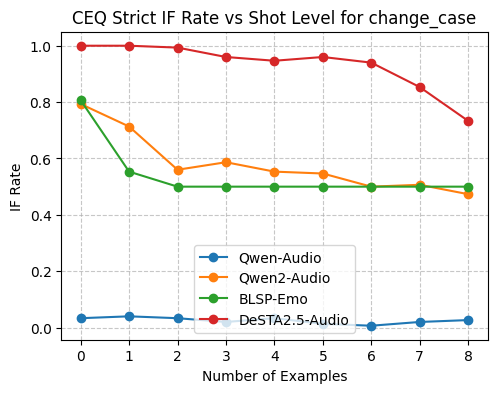

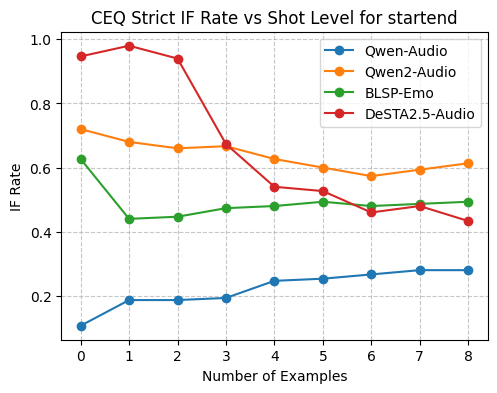

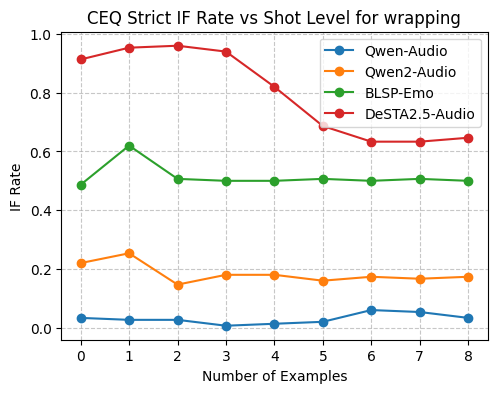

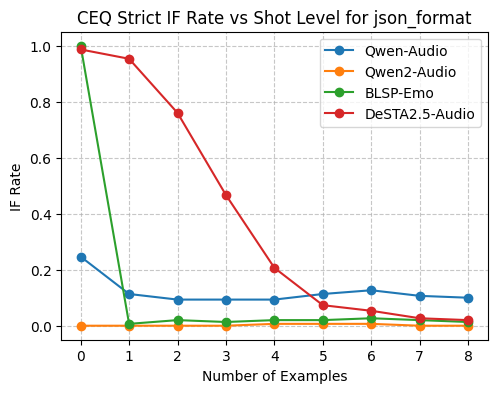

In [365]:
for group in GROUP_ORDER_CEQ:
    plt.figure(figsize=(5.5, 4))
    for model in MODEL_ORDER:
        sub_tmp = DF_ceq[(DF_ceq["IF_task_group"] == group) & (DF_ceq["model"] == model)]
        plt.plot(
            sub_tmp["shot_level"],
            sub_tmp["if_rate_strict"],
            marker='o',
            label=MAP_MODEL_NAME[model]
        )
    plt.title(f"CEQ Strict IF Rate vs Shot Level for {group}")
    plt.xlabel("Number of Examples")
    plt.ylabel("IF Rate")
    plt.xticks(range(9))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.savefig(f"./analysis/figures/plots_ceq_if_rate_{group}.png", dpi=300)

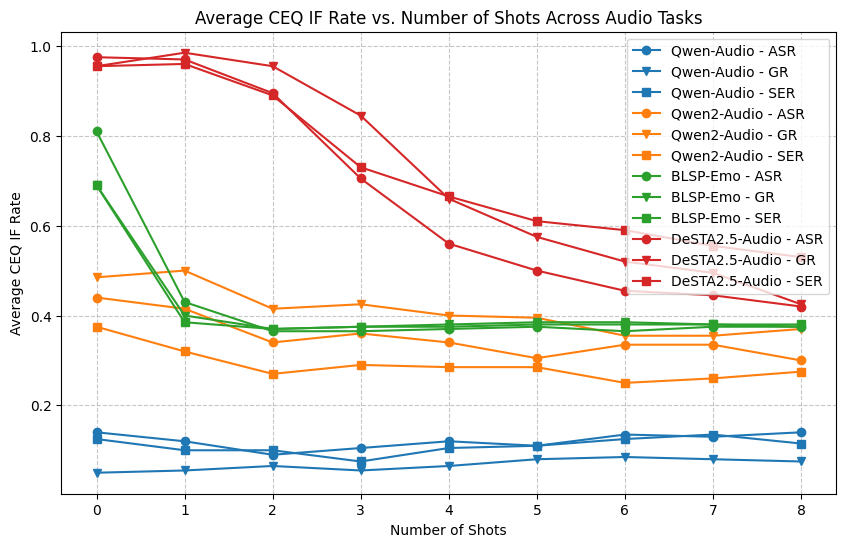

In [214]:
tmp = pd.DataFrame(avg)  # columns: ASR/SER/GR ; index: models ; each cell is a list over shots
# x-axis (0..N-1) based on the length of the first series
shot_levels = list(range(9))
# one color per model (use matplotlib default cycle)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_color = {m: colors[i % len(colors)] for i, m in enumerate(MODEL_ORDER)}
# different markers per task
marker_map = {"ASR": "o", "SER": "s", "GR": "v"}  # adjust if your column names differ
plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    for audio_task in tmp.columns:
        y = tmp.loc[model, audio_task]
        plt.plot(
            shot_levels, y,
            color=model_color[model],
            marker=marker_map[audio_task],
            label=f"{MAP_MODEL_NAME[model]} - {audio_task}",
        )

plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots Across Audio Tasks")
plt.show()


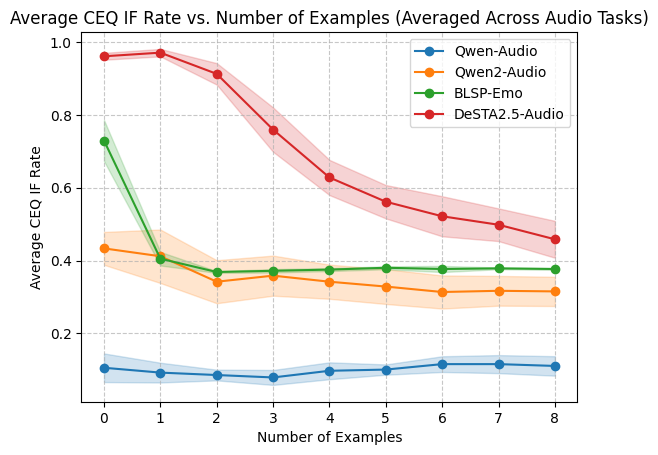

In [408]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
# plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]}",
    )
    plt.fill_between(
        shot_levels,
        y - std["avg"][model],
        y + std["avg"][model],
        alpha=0.2,
        color=model_color[model],
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Examples")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Examples (Averaged Across Audio Tasks)")
plt.savefig(f"./analysis/figures/plots_ceq_if_rate_avg.png", dpi=300)
plt.show()

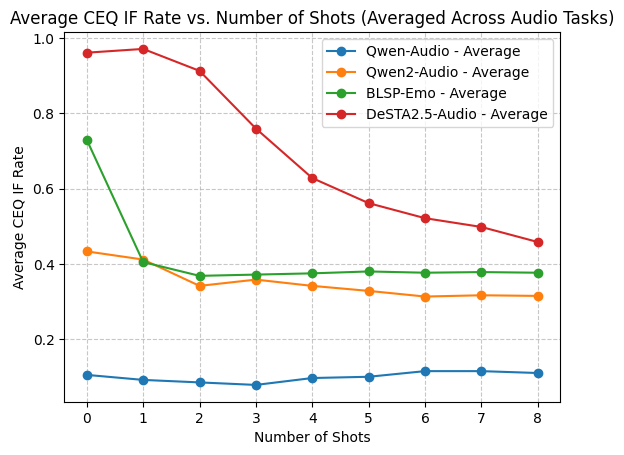

In [217]:
tmp = pd.DataFrame(avg)
avg["avg"] = tmp.mean(axis=1)
std["avg"] = tmp.std(axis=1)
# plt.figure(figsize=(10, 6))
for model in MODEL_ORDER:
    y = avg["avg"][model]
    plt.plot(
        shot_levels, y,
        color=model_color[model],
        marker="o",
        label=f"{MAP_MODEL_NAME[model]} - Average",
    )
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.xlabel("Number of Shots")
plt.ylabel("Average CEQ IF Rate")
plt.title("Average CEQ IF Rate vs. Number of Shots (Averaged Across Audio Tasks)")
plt.show()

In [ ]:
outs = {}
for k, v in df_audio_task_ceq.items():
    outs[k] = []
    for shot_level in v["shot_level"].unique():
        tmp = v.loc[v["shot_level"].eq(shot_level)].copy()
        tmp["model"] = pd.Categorical(tmp["model"], categories=MODEL_ORDER, ordered=True)
        tmp["IF_task_group"] = pd.Categorical(tmp["IF_task_group"], categories=GROUP_ORDER_CEQ, ordered=True)

        out = tmp.pivot_table(
            index="model",
            columns="IF_task_group",
            values="if_rate_strict",
            aggfunc="mean",
            observed=False,
            sort=False,
        )
        outs[k].append(out)

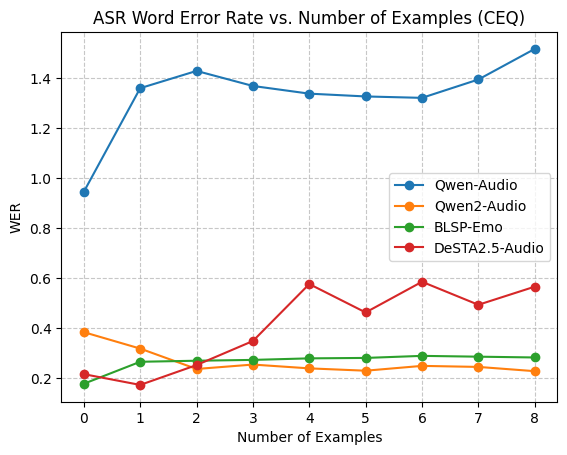

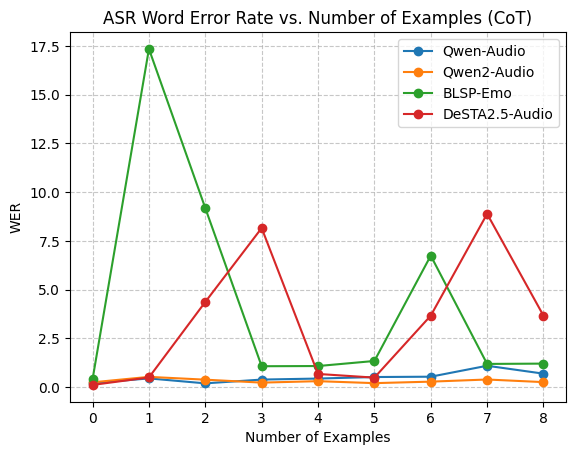

In [404]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["ASR"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("WER")
    plt.title(f"ASR Word Error Rate vs. Number of Examples ({resp})")
    plt.savefig(f"./analysis/figures/plots_asr_wer_{resp}.png", dpi=300)
    plt.show()

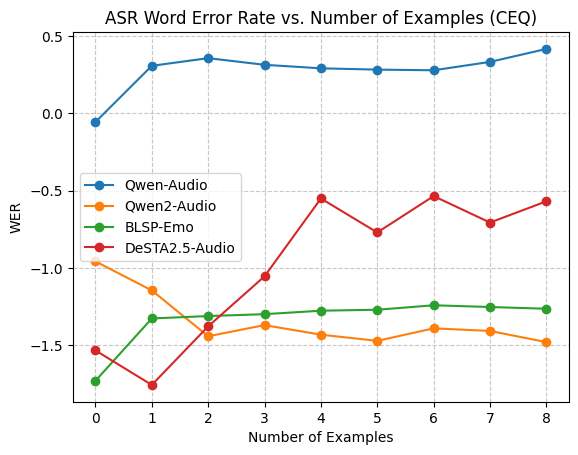

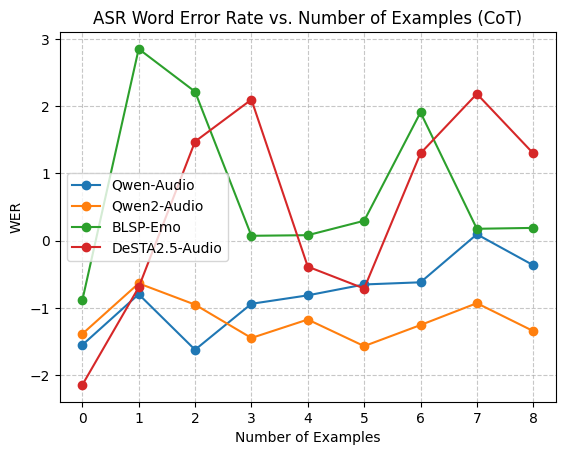

In [405]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["ASR"][resp][model]
        plt.plot(np.log(y), label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("WER")
    plt.title(f"ASR Word Error Rate vs. Number of Examples ({resp})")
    plt.savefig(f"./analysis/figures/plots_asr_wer_log_{resp}.png", dpi=300)
    plt.show()

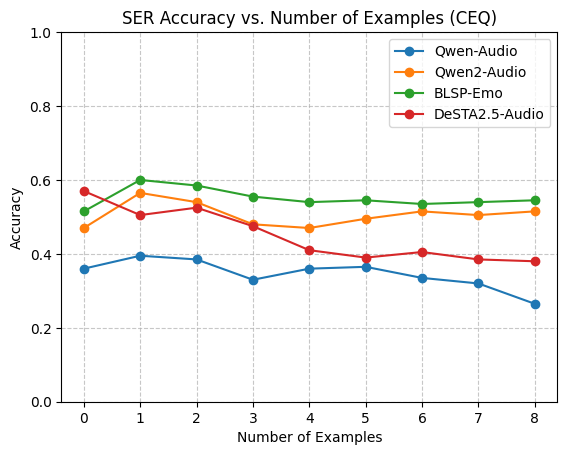

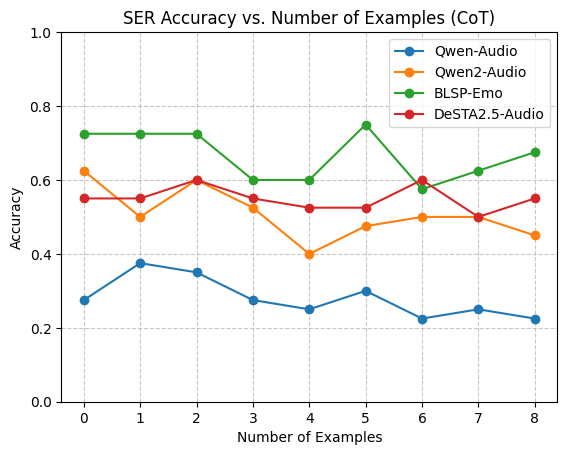

In [406]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["SER"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"SER Accuracy vs. Number of Examples ({resp})")
    plt.savefig(f"./analysis/figures/plots_ser_acc_{resp}.png", dpi=300)
    plt.show()


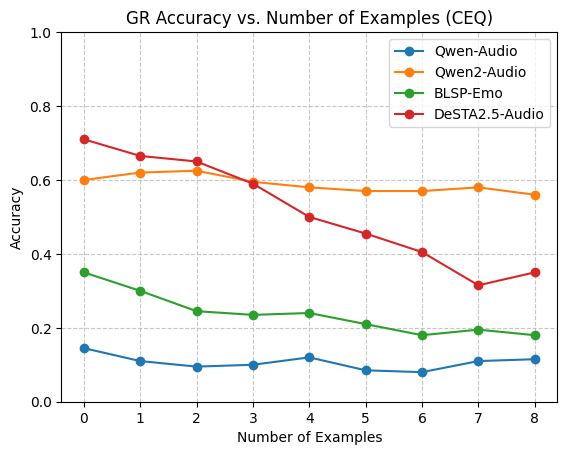

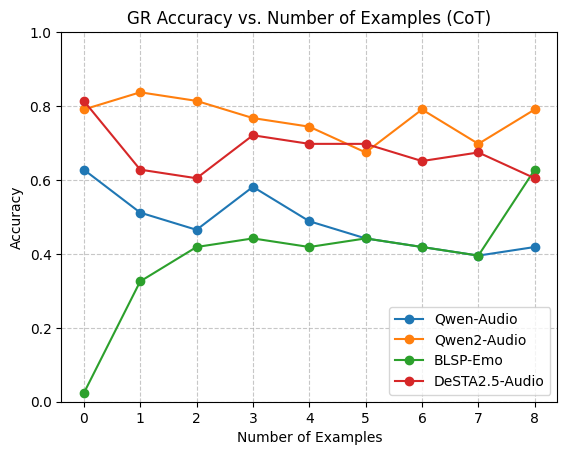

In [407]:
for resp in ["CEQ", "CoT"]:
    for model in MODEL_ORDER:
        y = pt_audio_tasks["mean_performance"]["GR"][resp][model]
        plt.plot(y, label=MAP_MODEL_NAME[model], marker="o")
    plt.legend(fontsize=10)
    plt.grid(linestyle="--", alpha=0.7)
    plt.xlabel("Number of Examples")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"GR Accuracy vs. Number of Examples ({resp})")
    plt.savefig(f"./analysis/figures/plots_gr_acc_{resp}.png", dpi=300)
    plt.show()